# 🏦 KYC/KYT Fraud Detection System
## Czech Bank Dataset (PKDD 1999) - Complete Pipeline

**Dataset:** Download from https://www.kaggle.com/datasets/marceloventura/the-berka-dataset

### Feature Ranking Strategy

| Tier | Category | Features | Best Models |
|------|----------|----------|-------------|
| 🥇 Tier 1 | KYT Sequential | amount, balance_diff, time_delta | LSTM, Autoencoder |
| 🥈 Tier 2 | KYT Aggregated | moving_avg, z_score, tx_count | XGBoost, LightGBM |
| 🥉 Tier 3 | KYC Context | client_age, account_age, district | Ensemble fine-tuning |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
from scipy.stats import ks_2samp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import (average_precision_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, 
                             precision_recall_curve, roc_curve, classification_report)
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

plt.style.use('seaborn-v0_8-whitegrid')
COLORS = {'good': '#2ecc71', 'bad': '#e74c3c', 'neutral': '#3498db'}

print("Environment ready")

Environment ready


## 1. Load Data

In [2]:
# Configure data path - adjust to your location
DATA_DIR = Path('.')  # Current directory

# Try to find data files
possible_dirs = [Path('.'), Path('data'), Path('berka'), Path('../data')]
for d in possible_dirs:
    if (d / 'account.asc').exists() or (d / 'account.csv').exists():
        DATA_DIR = d
        break

print(f"Data directory: {DATA_DIR}")
print(f"Files found: {list(DATA_DIR.glob('*.asc')) + list(DATA_DIR.glob('*.csv'))}")

Data directory: .
Files found: [WindowsPath('account.csv'), WindowsPath('card.csv'), WindowsPath('client.csv'), WindowsPath('disp.csv'), WindowsPath('district.csv'), WindowsPath('loan.csv'), WindowsPath('order.csv'), WindowsPath('trans.csv')]


In [3]:
def load_table(name, data_dir):
    """Load a table from .asc or .csv format."""
    for ext in ['.asc', '.csv', '.ASC', '.CSV']:
        path = data_dir / f"{name}{ext}"
        if path.exists():
            try:
                # Try semicolon separator (Czech format with quotes)
                df = pd.read_csv(path, sep=';', low_memory=False, quotechar='"')
                if len(df.columns) == 1:  # Wrong separator
                    df = pd.read_csv(path, sep=',', low_memory=False)
                # Clean column names
                df.columns = df.columns.str.strip().str.replace('"', '')
                # Clean string columns (remove quotes)
                for col in df.select_dtypes(include=['object']).columns:
                    df[col] = df[col].astype(str).str.strip().str.replace('"', '')
                print(f"  {name}: {len(df):,} rows, cols: {list(df.columns)}")
                return df
            except Exception as e:
                print(f"  Error loading {name}: {e}")
    return pd.DataFrame()

print("Loading tables...")
account = load_table('account', DATA_DIR)
client = load_table('client', DATA_DIR)
disp = load_table('disp', DATA_DIR)
trans = load_table('trans', DATA_DIR)
loan = load_table('loan', DATA_DIR)
card = load_table('card', DATA_DIR)
district = load_table('district', DATA_DIR)

Loading tables...
  account: 4,500 rows, cols: ['account_id', 'district_id', 'frequency', 'date']
  client: 5,369 rows, cols: ['client_id', 'birth_number', 'district_id']
  disp: 5,369 rows, cols: ['disp_id', 'client_id', 'account_id', 'type']
  trans: 1,056,320 rows, cols: ['trans_id', 'account_id', 'date', 'type', 'operation', 'amount', 'balance', 'k_symbol', 'bank', 'account']
  loan: 682 rows, cols: ['loan_id', 'account_id', 'date', 'amount', 'duration', 'payments', 'status']
  card: 892 rows, cols: ['card_id', 'disp_id', 'type', 'issued']
  district: 77 rows, cols: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']


In [4]:
# If no data found, create synthetic for demonstration
if len(loan) == 0:
    print("\n⚠️ Creating synthetic data for demonstration...")
    print("Download real data from Kaggle for actual analysis\n")
    
    np.random.seed(42)
    n_accounts, n_clients, n_trans, n_loans = 4500, 5369, 100000, 682
    
    account = pd.DataFrame({
        'account_id': range(1, n_accounts + 1),
        'district_id': np.random.randint(1, 78, n_accounts),
        'frequency': np.random.choice(['POPLATEK MESICNE', 'POPLATEK TYDNE', 'POPLATEK PO OBRATU'], n_accounts),
        'date': np.random.randint(930101, 980101, n_accounts)
    })
    
    client = pd.DataFrame({
        'client_id': range(1, n_clients + 1),
        'birth_number': [f"{np.random.randint(40, 90)}{np.random.randint(1, 13):02d}{np.random.randint(1, 28):02d}" 
                        for _ in range(n_clients)],
        'district_id': np.random.randint(1, 78, n_clients)
    })
    
    disp = pd.DataFrame({
        'disp_id': range(1, n_clients + 1),
        'client_id': range(1, n_clients + 1),
        'account_id': np.random.randint(1, n_accounts + 1, n_clients),
        'type': np.random.choice(['OWNER', 'DISPONENT'], n_clients, p=[0.85, 0.15])
    })
    
    trans = pd.DataFrame({
        'trans_id': range(1, n_trans + 1),
        'account_id': np.random.randint(1, n_accounts + 1, n_trans),
        'date': np.random.randint(930101, 981231, n_trans),
        'type': np.random.choice(['PRIJEM', 'VYDAJ'], n_trans, p=[0.45, 0.55]),
        'operation': np.random.choice(['VKLAD', 'VYBER', 'PREVOD Z UCTU', 'PREVOD NA UCET'], n_trans),
        'amount': np.abs(np.random.exponential(5000, n_trans)),
        'balance': np.random.uniform(0, 100000, n_trans),
        'k_symbol': np.random.choice(['POJISTNE', 'UVER', 'SIPO', ' '], n_trans),
        'bank': np.random.choice(['AB', 'CD', 'EF', ' '], n_trans),
        'account': np.random.randint(0, 100000, n_trans)
    })
    
    loan = pd.DataFrame({
        'loan_id': range(1, n_loans + 1),
        'account_id': np.random.choice(range(1, n_accounts + 1), n_loans, replace=False),
        'date': np.random.randint(940101, 981231, n_loans),
        'amount': np.random.uniform(10000, 500000, n_loans),
        'duration': np.random.choice([12, 24, 36, 48, 60], n_loans),
        'payments': np.random.uniform(500, 10000, n_loans),
        'status': np.random.choice(['A', 'B', 'C', 'D'], n_loans, p=[0.75, 0.10, 0.10, 0.05])
    })
    
    district = pd.DataFrame({
        'A1': range(1, 78),
        'A2': [f'District_{i}' for i in range(1, 78)],
        'A3': np.random.choice(['Prague', 'Central', 'South', 'North'], 77),
        'A4': np.random.randint(10000, 1000000, 77),
        'A11': np.random.uniform(8000, 15000, 77),
        'A12': np.random.uniform(0, 10, 77),
        'A13': np.random.uniform(0, 10, 77),
        'A15': np.random.randint(100, 50000, 77),
        'A16': np.random.randint(100, 50000, 77)
    })
    
    print("Synthetic data created!")

## 2. EDA - Target Variable Analysis

In [5]:
print("="*60)
print("TARGET VARIABLE: LOAN STATUS")
print("="*60)

# Debug: show actual columns
print(f"\nLoan columns: {list(loan.columns)}")
print(f"Loan shape: {loan.shape}")

# Standardize column names if needed
if 'status' not in loan.columns:
    # Check if columns are numeric (no header was read)
    if len(loan.columns) >= 7:
        loan.columns = ['loan_id', 'account_id', 'date', 'amount', 'duration', 'payments', 'status']
        print(f"Renamed columns to: {list(loan.columns)}")

status_map = {
    'A': '✓ Good - Finished OK',
    'B': '✓ Good - Finished (minor issues)',
    'C': '⚠️ Running - OK so far',
    'D': '🚨 BAD - DEFAULT/FRAUD'
}

print("\nLoan Status Distribution:")
for status, count in loan['status'].value_counts().items():
    pct = count / len(loan) * 100
    print(f"  {status}: {count:,} ({pct:.1f}%) - {status_map.get(status, 'Unknown')}")

# Create binary target
loan['is_bad'] = (loan['status'] == 'D').astype(int)
print(f"\n📌 Bad Loan Rate: {loan['is_bad'].mean()*100:.2f}%")

TARGET VARIABLE: LOAN STATUS

Loan columns: ['loan_id', 'account_id', 'date', 'amount', 'duration', 'payments', 'status']
Loan shape: (682, 7)

Loan Status Distribution:
  C: 403 (59.1%) - ⚠️ Running - OK so far
  A: 203 (29.8%) - ✓ Good - Finished OK
  D: 45 (6.6%) - 🚨 BAD - DEFAULT/FRAUD
  B: 31 (4.5%) - ✓ Good - Finished (minor issues)

📌 Bad Loan Rate: 6.60%


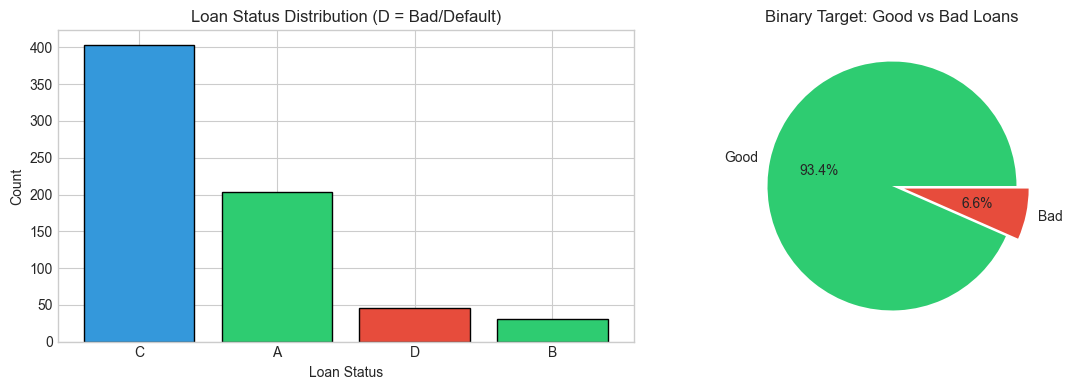

In [6]:
# Visualize target
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Status distribution
status_counts = loan['status'].value_counts()
colors = [COLORS['good'] if s in ['A','B'] else COLORS['bad'] if s=='D' else COLORS['neutral'] 
          for s in status_counts.index]
axes[0].bar(status_counts.index, status_counts.values, color=colors, edgecolor='black')
axes[0].set_xlabel('Loan Status')
axes[0].set_ylabel('Count')
axes[0].set_title('Loan Status Distribution (D = Bad/Default)')

# Binary target
bad_counts = loan['is_bad'].value_counts()
axes[1].pie(bad_counts.values, labels=['Good', 'Bad'], autopct='%1.1f%%',
           colors=[COLORS['good'], COLORS['bad']], explode=[0, 0.1])
axes[1].set_title('Binary Target: Good vs Bad Loans')

plt.tight_layout()
plt.show()

## 3. EDA - KYT Analysis (Transactions)

In [7]:
print("="*60)
print("KYT ANALYSIS - TRANSACTION PATTERNS")
print("="*60)

# Standardize column names
if len(trans.columns) >= 10 and 'amount' not in trans.columns:
    trans.columns = ['trans_id', 'account_id', 'date', 'type', 'operation', 
                     'amount', 'balance', 'k_symbol', 'bank', 'account']

print(f"\nTransactions: {len(trans):,}")
print(f"Accounts: {trans['account_id'].nunique():,}")
print(f"Avg transactions per account: {len(trans)/trans['account_id'].nunique():.0f}")

print(f"\nAmount Statistics:")
print(trans['amount'].describe())

KYT ANALYSIS - TRANSACTION PATTERNS

Transactions: 1,056,320
Accounts: 4,500
Avg transactions per account: 235

Amount Statistics:
count    1.056320e+06
mean     5.924146e+03
std      9.522735e+03
min      0.000000e+00
25%      1.359000e+02
50%      2.100000e+03
75%      6.800000e+03
max      8.740000e+04
Name: amount, dtype: float64


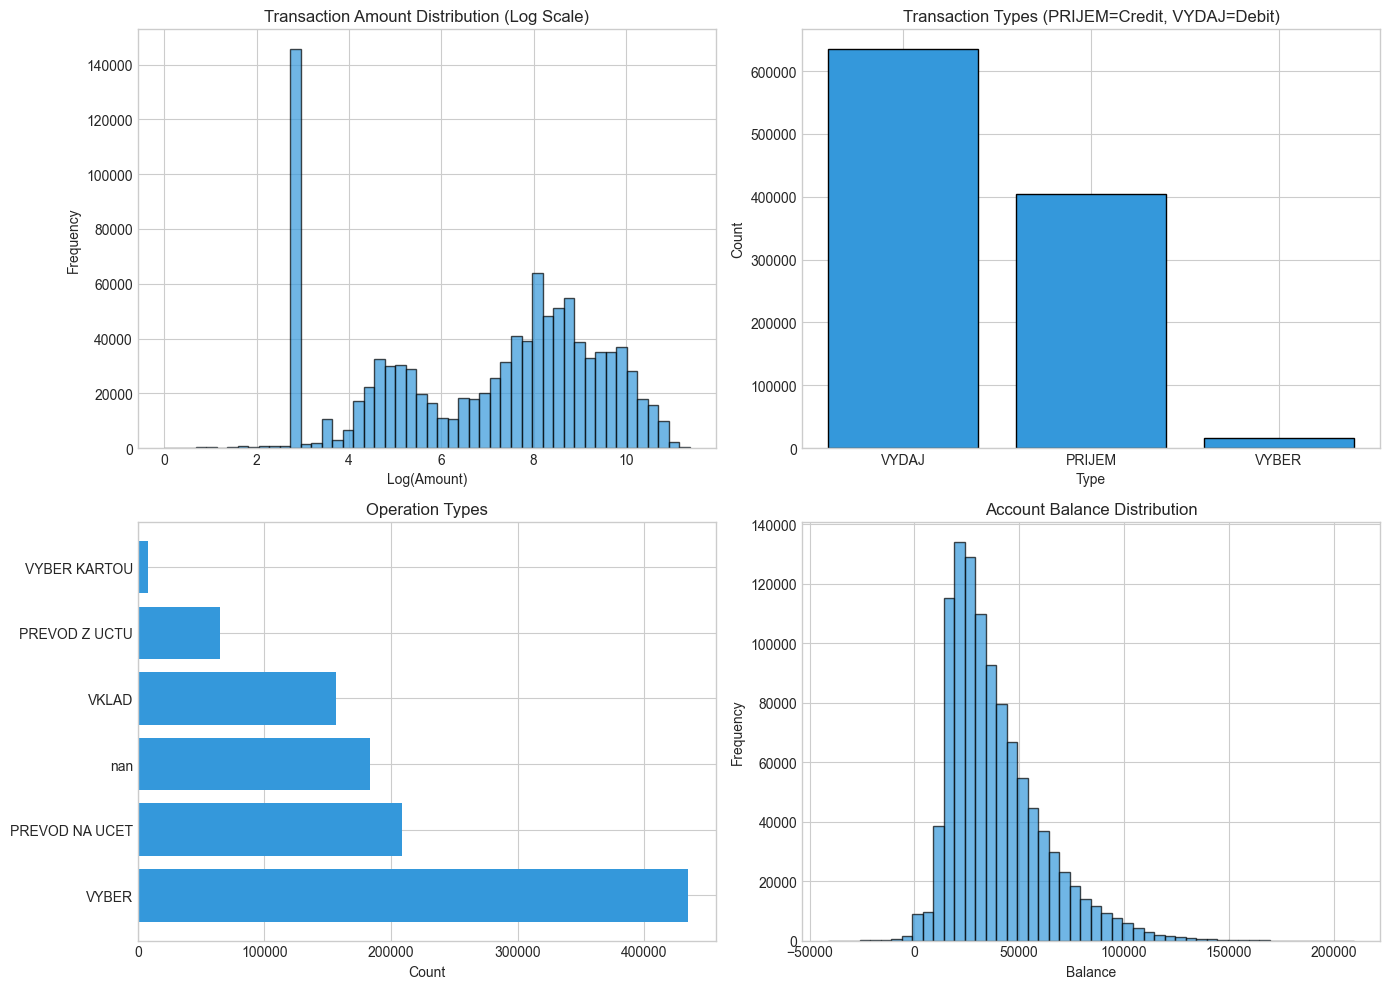

In [8]:
# Transaction visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Amount distribution (log)
axes[0,0].hist(np.log1p(trans['amount']), bins=50, color=COLORS['neutral'], edgecolor='black', alpha=0.7)
axes[0,0].set_xlabel('Log(Amount)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Transaction Amount Distribution (Log Scale)')

# Transaction type
type_counts = trans['type'].value_counts()
axes[0,1].bar(type_counts.index, type_counts.values, color=COLORS['neutral'], edgecolor='black')
axes[0,1].set_xlabel('Type')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Transaction Types (PRIJEM=Credit, VYDAJ=Debit)')

# Operation type
op_counts = trans['operation'].value_counts().head(6)
axes[1,0].barh(op_counts.index.astype(str), op_counts.values, color=COLORS['neutral'])
axes[1,0].set_xlabel('Count')
axes[1,0].set_title('Operation Types')

# Balance distribution
axes[1,1].hist(trans['balance'], bins=50, color=COLORS['neutral'], edgecolor='black', alpha=0.7)
axes[1,1].set_xlabel('Balance')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Account Balance Distribution')

plt.tight_layout()
plt.show()

In [9]:
# Create account-level transaction features
print("\nCreating account-level KYT features...")

account_trans = trans.groupby('account_id').agg({
    'trans_id': 'count',
    'amount': ['mean', 'std', 'min', 'max', 'sum', 'median'],
    'balance': ['mean', 'std', 'min', 'max']
})
account_trans.columns = ['_'.join(col) for col in account_trans.columns]
account_trans = account_trans.rename(columns={'trans_id_count': 'n_transactions'})

# Add transaction type percentages
type_pct = trans.groupby('account_id')['type'].value_counts(normalize=True).unstack(fill_value=0)
type_pct.columns = [f'pct_{c}' for c in type_pct.columns]
account_trans = account_trans.join(type_pct)

print(f"Account features created: {account_trans.shape}")
account_trans.head()


Creating account-level KYT features...
Account features created: (4500, 14)


,n_transactions,amount_mean,amount_std,amount_min,amount_max,amount_sum,amount_median,balance_mean,balance_std,balance_min,balance_max,pct_PRIJEM,pct_VYBER,pct_VYDAJ
account_id,,,,,,,,,,,,,,
1,239,1569.767782,1732.180986,14.6,12600.0,375174.5,870.0,15994.008368,3656.890437,1000.0,30414.8,0.426778,0.000000,0.573222
2,478,6593.052929,7694.570797,13.5,42000.0,3151479.3,3600.0,36540.704393,11028.141344,1100.0,69302.0,0.317992,0.043933,0.638075
3,117,2521.553846,2951.359708,14.6,11253.0,295021.8,1135.0,26973.506838,10508.662466,1000.0,53446.5,0.393162,0.000000,0.606838
4,186,1886.943011,1956.904491,14.6,5553.0,350971.4,1285.0,21753.446237,5009.975052,800.0,34870.0,0.349462,0.000000,0.650538
5,84,1986.683333,1981.275908,3.5,5100.0,166881.4,1400.0,25090.069048,4752.471004,600.0,32036.2,0.416667,0.000000,0.583333


## 4. EDA - Pairwise Analysis (Good vs Bad)

In [10]:
print("="*60)
print("PAIRWISE DISTRIBUTION ANALYSIS")
print("="*60)

# Merge loan with transaction features
loan_features = loan.merge(account_trans, left_on='account_id', right_index=True, how='left')
print(f"\nMerged dataset: {len(loan_features)} loans with {len(loan_features.columns)} features")

PAIRWISE DISTRIBUTION ANALYSIS

Merged dataset: 682 loans with 22 features


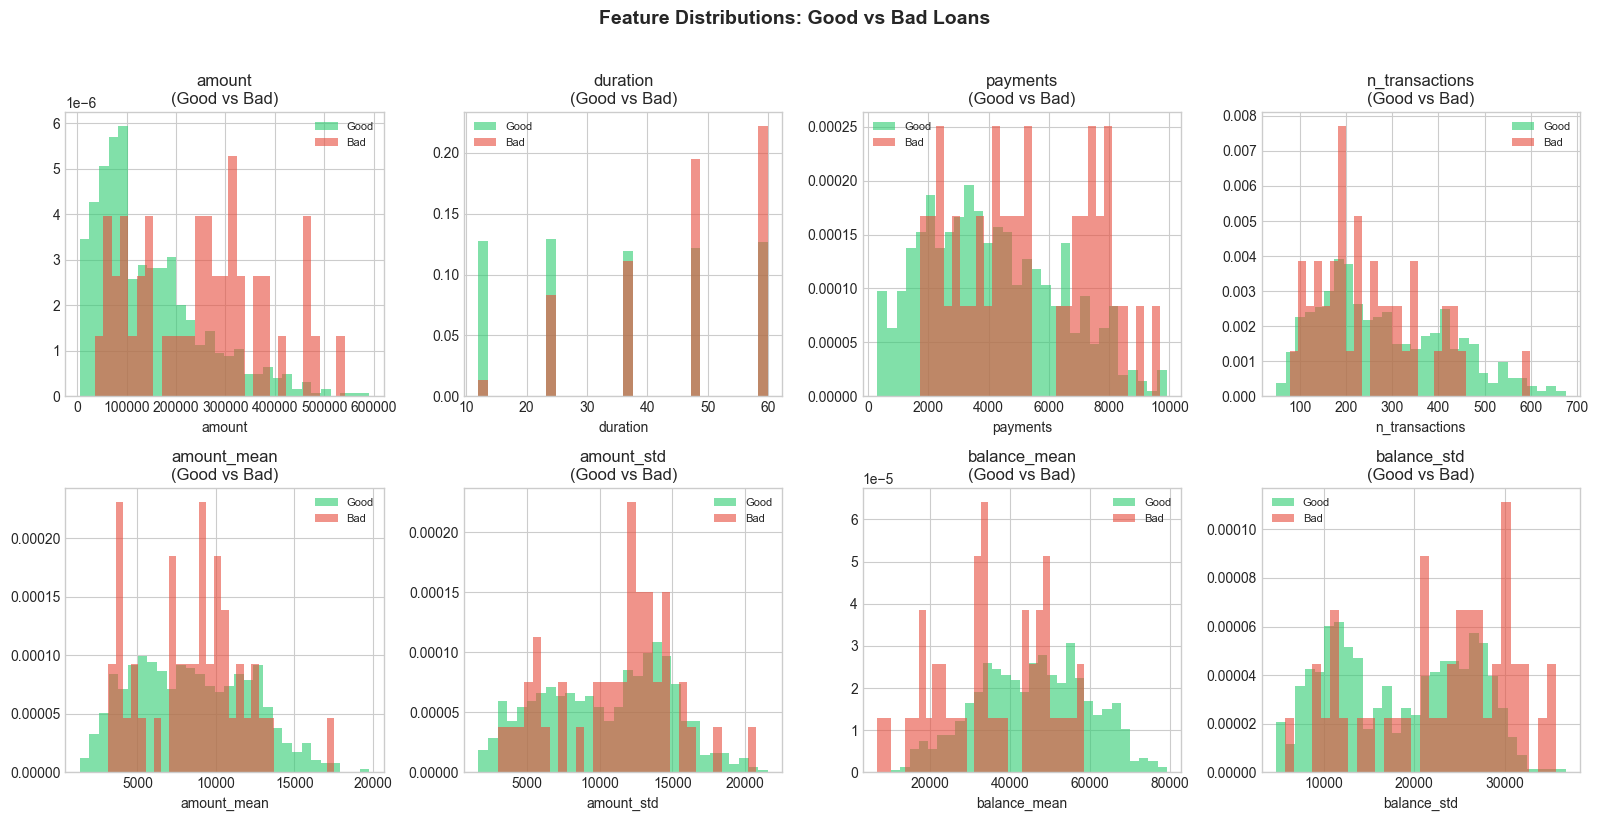

In [11]:
# Distribution comparison: Good vs Bad loans
key_features = ['amount', 'duration', 'payments', 'n_transactions', 
                'amount_mean', 'amount_std', 'balance_mean', 'balance_std']
available = [f for f in key_features if f in loan_features.columns]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, col in enumerate(available[:8]):
    ax = axes[idx]
    good = loan_features[loan_features['is_bad']==0][col].dropna()
    bad = loan_features[loan_features['is_bad']==1][col].dropna()
    
    ax.hist(good, bins=30, alpha=0.6, color=COLORS['good'], label='Good', density=True)
    ax.hist(bad, bins=30, alpha=0.6, color=COLORS['bad'], label='Bad', density=True)
    ax.set_xlabel(col)
    ax.set_title(f'{col}\n(Good vs Bad)')
    ax.legend(fontsize=8)

plt.suptitle('Feature Distributions: Good vs Bad Loans', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

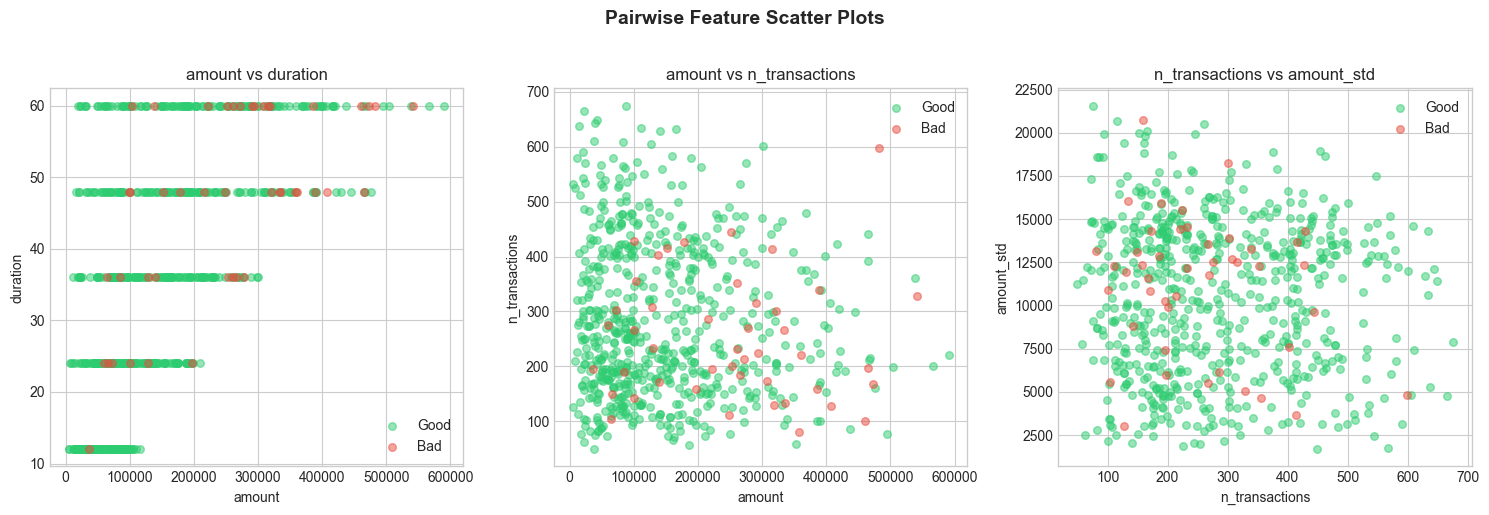

In [12]:
# Pairwise scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

pairs = [('amount', 'duration'), ('amount', 'n_transactions'), ('n_transactions', 'amount_std')]

for idx, (x, y) in enumerate(pairs):
    if x in loan_features.columns and y in loan_features.columns:
        ax = axes[idx]
        for status, color, label in [(0, COLORS['good'], 'Good'), (1, COLORS['bad'], 'Bad')]:
            mask = loan_features['is_bad'] == status
            ax.scatter(loan_features.loc[mask, x], loan_features.loc[mask, y],
                      c=color, alpha=0.5, s=30, label=label)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_title(f'{x} vs {y}')
        ax.legend()

plt.suptitle('Pairwise Feature Scatter Plots', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 5. Feature Discrimination Power

In [13]:
print("="*60)
print("FEATURE DISCRIMINATION POWER")
print("="*60)

def calc_discrimination(df, target, features):
    results = []
    for col in features:
        if col not in df.columns or col == target:
            continue
        good = df[df[target]==0][col].dropna()
        bad = df[df[target]==1][col].dropna()
        if len(good) < 10 or len(bad) < 5:
            continue
        
        # Cohen's d
        pooled_std = np.sqrt((good.std()**2 + bad.std()**2) / 2)
        cohens_d = abs(bad.mean() - good.mean()) / (pooled_std + 1e-8)
        
        # KS test
        ks_stat, _ = ks_2samp(good, bad)
        
        results.append({
            'feature': col,
            'cohens_d': cohens_d,
            'ks_stat': ks_stat,
            'mean_good': good.mean(),
            'mean_bad': bad.mean(),
            'diff_pct': (bad.mean() - good.mean()) / (good.mean() + 1e-8) * 100
        })
    return pd.DataFrame(results).sort_values('cohens_d', ascending=False)

numeric_cols = loan_features.select_dtypes(include=[np.number]).columns.tolist()
discrimination = calc_discrimination(loan_features, 'is_bad', numeric_cols)

print("\nTop 15 Most Discriminative Features:")
discrimination.head(15)

FEATURE DISCRIMINATION POWER

Top 15 Most Discriminative Features:


,feature,cohens_d,ks_stat,mean_good,mean_bad,diff_pct
9,amount_min,1.691259,0.842282,1.593469e+01,2.733333e+00,-82.846653
15,balance_min,1.337549,0.951334,5.514909e+02,-4.598122e+03,-933.762128
3,amount,0.863851,0.412943,1.444960e+05,2.492845e+05,72.520054
13,balance_mean,0.757142,0.315123,4.562502e+04,3.517094e+04,-22.913027
4,duration,0.669427,0.269492,3.581162e+01,4.613333e+01,28.822257
19,pct_VYDAJ,0.622208,0.327577,6.031253e-01,5.546905e-01,-8.030637
14,balance_std,0.620391,0.284110,1.843794e+04,2.325488e+04,26.125177
17,pct_PRIJEM,0.603713,0.311530,3.643547e-01,4.043979e-01,10.990166
5,payments,0.527901,0.231781,4.113240e+03,5.286644e+03,28.527492
10,amount_max,0.323473,0.251875,4.441196e+04,5.024713e+04,13.138731


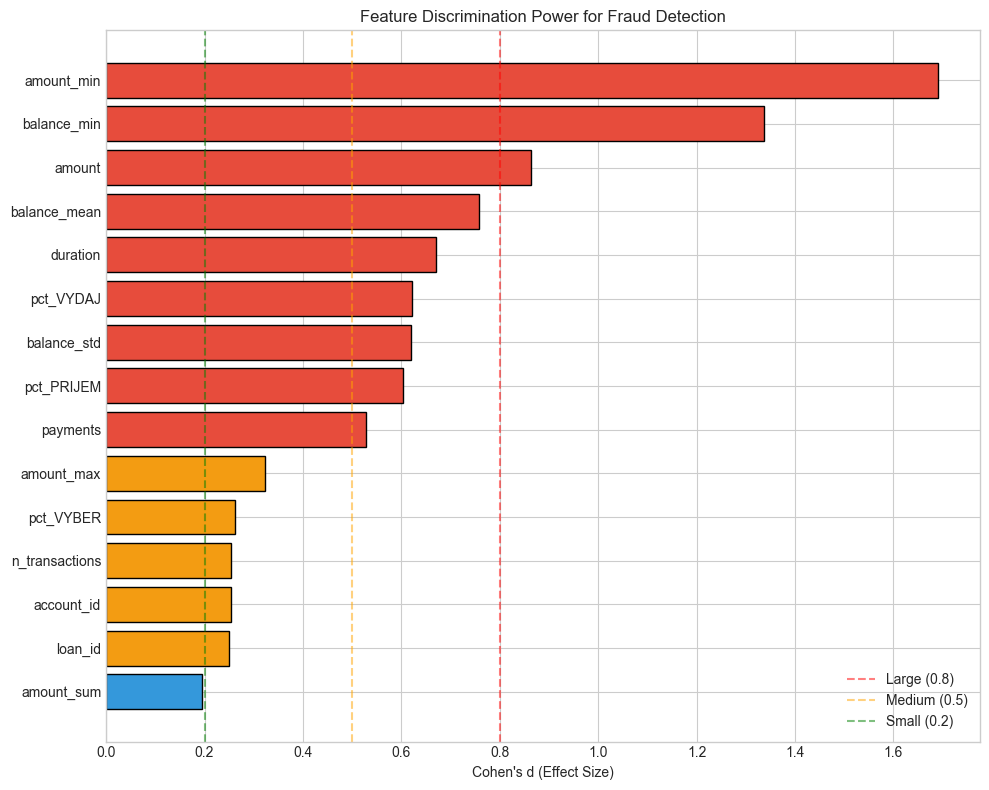

In [14]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 8))

top_15 = discrimination.head(15)
colors = ['#e74c3c' if x > 0.5 else '#f39c12' if x > 0.2 else '#3498db' for x in top_15['cohens_d']]

ax.barh(top_15['feature'], top_15['cohens_d'], color=colors, edgecolor='black')
ax.axvline(x=0.8, color='red', linestyle='--', alpha=0.5, label='Large (0.8)')
ax.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Medium (0.5)')
ax.axvline(x=0.2, color='green', linestyle='--', alpha=0.5, label='Small (0.2)')
ax.set_xlabel("Cohen's d (Effect Size)")
ax.set_title('Feature Discrimination Power for Fraud Detection')
ax.legend(loc='lower right')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

## 6. Feature Engineering

In [15]:
print("="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Start with loan + transaction features
df = loan_features.copy()

# Additional features
df['payment_ratio'] = df['payments'] / (df['amount'] + 1)
df['amount_per_duration'] = df['amount'] / (df['duration'] + 1)

if 'n_transactions' in df.columns and 'amount_sum' in df.columns:
    df['avg_trans_amount'] = df['amount_sum'] / (df['n_transactions'] + 1)

if 'amount_std' in df.columns and 'amount_mean' in df.columns:
    df['amount_cv'] = df['amount_std'] / (df['amount_mean'] + 1)  # Coefficient of variation

if 'balance_min' in df.columns:
    df['has_negative_balance'] = (df['balance_min'] < 0).astype(int)

print(f"\nFinal features: {df.shape[1]}")
print(f"Samples: {len(df)}")

FEATURE ENGINEERING

Final features: 27
Samples: 682


In [16]:
# Prepare feature matrix
exclude_cols = ['loan_id', 'account_id', 'date', 'status', 'is_bad']
feature_cols = [c for c in df.columns if c not in exclude_cols 
                and df[c].dtype in ['int64', 'float64']]

X = df[feature_cols].fillna(0)
y = df['is_bad']

print(f"Feature matrix: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Feature matrix: (682, 22)
Target distribution: {0: 637, 1: 45}


In [17]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Scale
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {X_train_scaled.shape[0]} samples")
print(f"Test: {X_test_scaled.shape[0]} samples")

Training: 545 samples
Test: 137 samples


## 7. Modeling - Scalable ML (XGBoost)

In [18]:
print("="*60)
print("MODEL 1: XGBOOST (Production-Ready)")
print("="*60)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    eval_metric='aucpr',
    use_label_encoder=False
)

xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("\nXGBoost Results:")
print(f"  Precision: {precision_score(y_test, xgb_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, xgb_pred):.4f}")
print(f"  F1:        {f1_score(y_test, xgb_pred):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, xgb_proba):.4f}")
print(f"  Avg Prec:  {average_precision_score(y_test, xgb_proba):.4f}")

MODEL 1: XGBOOST (Production-Ready)

XGBoost Results:
  Precision: 0.7778
  Recall:    0.7778
  F1:        0.7778
  ROC-AUC:   0.9861
  Avg Prec:  0.7168


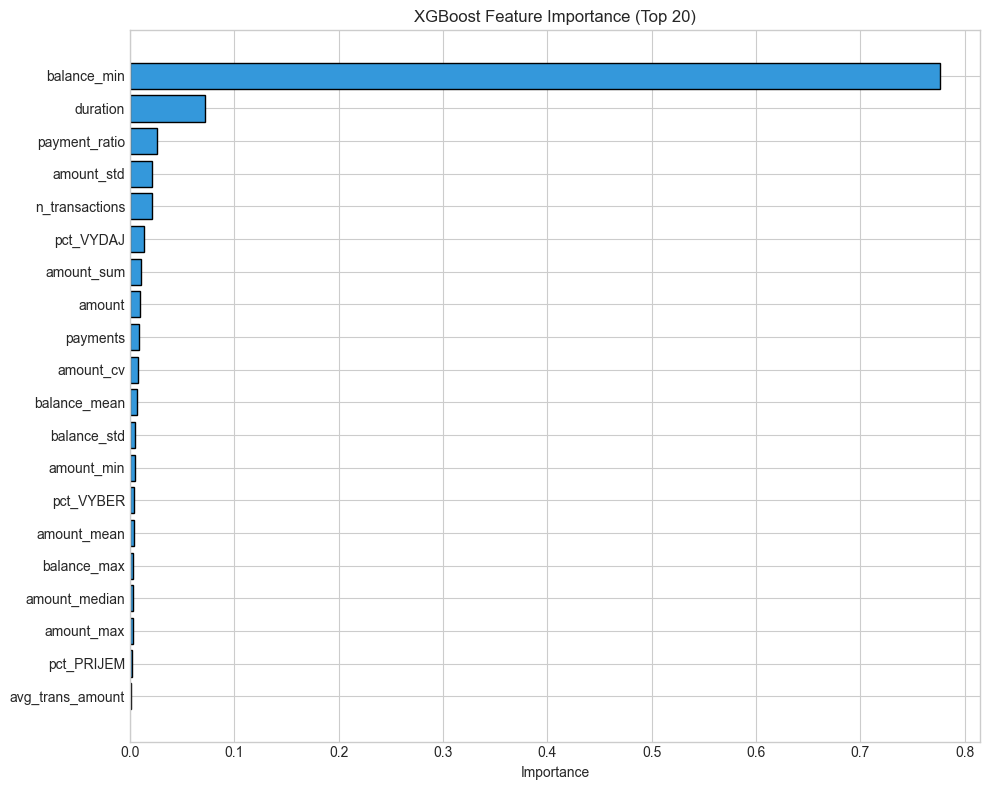

In [19]:
# Feature importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
top_20 = importance.head(20)
ax.barh(top_20['feature'], top_20['importance'], color=COLORS['neutral'], edgecolor='black')
ax.set_xlabel('Importance')
ax.set_title('XGBoost Feature Importance (Top 20)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 8. Modeling - Deep Learning (Autoencoder)

In [20]:
print("="*60)
print("MODEL 2: AUTOENCODER (Anomaly Detection)")
print("="*60)

# Train only on good loans
X_train_good = X_train_scaled[y_train == 0]
print(f"Training autoencoder on {len(X_train_good)} good loans")

# Build autoencoder
input_dim = X_train_scaled.shape[1]

inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(8, activation='relu')(x)  # Bottleneck
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(input_dim, activation='linear')(x)

autoencoder = keras.Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')

# Train
history = autoencoder.fit(
    X_train_good, X_train_good,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=0
)

print(f"Training completed in {len(history.history['loss'])} epochs")

MODEL 2: AUTOENCODER (Anomaly Detection)
Training autoencoder on 509 good loans
Training completed in 38 epochs


In [21]:
# Calculate reconstruction error
recon_test = autoencoder.predict(X_test_scaled, verbose=0)
ae_errors = np.mean(np.power(X_test_scaled - recon_test, 2), axis=1)

# Normalize to probability
ae_proba = (ae_errors - ae_errors.min()) / (ae_errors.max() - ae_errors.min())

# Find threshold
recon_train = autoencoder.predict(X_train_good, verbose=0)
train_errors = np.mean(np.power(X_train_good - recon_train, 2), axis=1)
threshold = np.percentile(train_errors, 95)

ae_pred = (ae_errors > threshold).astype(int)

print("\nAutoencoder Results:")
print(f"  Precision: {precision_score(y_test, ae_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, ae_pred):.4f}")
print(f"  F1:        {f1_score(y_test, ae_pred):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, ae_proba):.4f}")
print(f"  Avg Prec:  {average_precision_score(y_test, ae_proba):.4f}")


Autoencoder Results:
  Precision: 0.4167
  Recall:    0.5556
  F1:        0.4762
  ROC-AUC:   0.9253
  Avg Prec:  0.4761


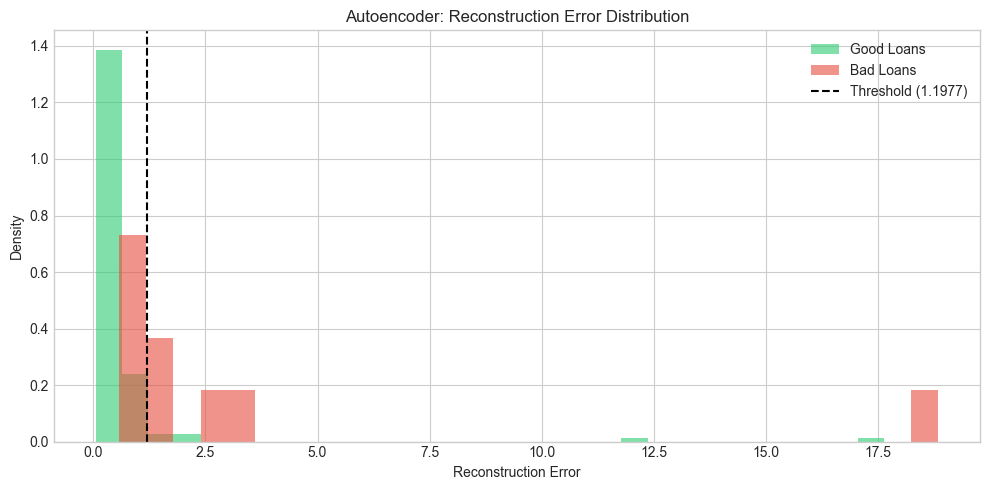

In [22]:
# Reconstruction error distribution
fig, ax = plt.subplots(figsize=(10, 5))

good_errors = ae_errors[y_test == 0]
bad_errors = ae_errors[y_test == 1]

ax.hist(good_errors, bins=30, alpha=0.6, color=COLORS['good'], label='Good Loans', density=True)
ax.hist(bad_errors, bins=30, alpha=0.6, color=COLORS['bad'], label='Bad Loans', density=True)
ax.axvline(threshold, color='black', linestyle='--', label=f'Threshold ({threshold:.4f})')
ax.set_xlabel('Reconstruction Error')
ax.set_ylabel('Density')
ax.set_title('Autoencoder: Reconstruction Error Distribution')
ax.legend()

plt.tight_layout()
plt.show()

## 9. Model Comparison

In [23]:
print("="*60)
print("MODEL COMPARISON")
print("="*60)

results = pd.DataFrame({
    'Model': ['XGBoost', 'Autoencoder'],
    'Precision': [precision_score(y_test, xgb_pred), precision_score(y_test, ae_pred)],
    'Recall': [recall_score(y_test, xgb_pred), recall_score(y_test, ae_pred)],
    'F1': [f1_score(y_test, xgb_pred), f1_score(y_test, ae_pred)],
    'ROC-AUC': [roc_auc_score(y_test, xgb_proba), roc_auc_score(y_test, ae_proba)],
    'Avg Precision': [average_precision_score(y_test, xgb_proba), average_precision_score(y_test, ae_proba)]
})

results

MODEL COMPARISON


,Model,Precision,Recall,F1,ROC-AUC,Avg Precision
0,XGBoost,0.777778,0.777778,0.777778,0.986111,0.716782
1,Autoencoder,0.416667,0.555556,0.476190,0.925347,0.476140


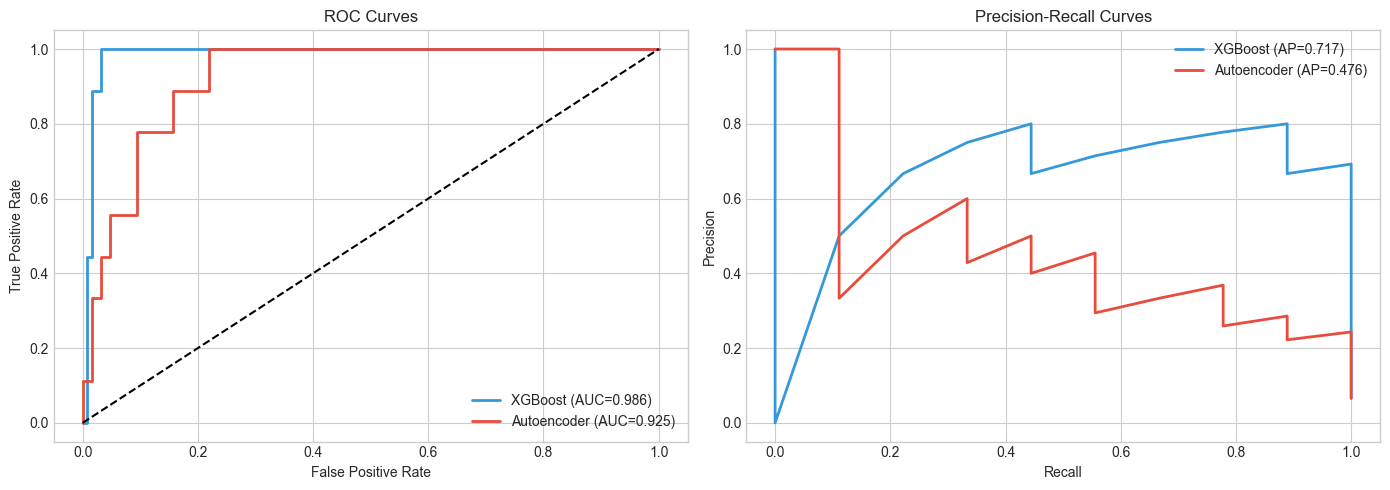

In [24]:
# ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC
for name, proba, color in [('XGBoost', xgb_proba, COLORS['neutral']), 
                            ('Autoencoder', ae_proba, COLORS['bad'])]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc_score = roc_auc_score(y_test, proba)
    axes[0].plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC={auc_score:.3f})')

axes[0].plot([0,1], [0,1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend()

# PR
for name, proba, color in [('XGBoost', xgb_proba, COLORS['neutral']), 
                            ('Autoencoder', ae_proba, COLORS['bad'])]:
    prec, rec, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    axes[1].plot(rec, prec, color=color, lw=2, label=f'{name} (AP={ap:.3f})')

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend()

plt.tight_layout()
plt.show()